In [56]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Support Range from Index 22: [312.09, 305.91]
Trough at index 4 in NOT within range.
Trough at index 7 in NOT within range.
Trough at index 11 in NOT within range.
Support Range from Index 33: [290.8117892456055, 285.05313995361325]
Trough at index 22 in NOT within range.
Support Range from Index 45: [283.1518109130859, 277.5448443603516]
Trough at index 33 in NOT within range.
Support Range from Index 57: [296.76711517333985, 290.8905386352539]
Trough at index 45 in NOT within range.
Support Range from Index 63: [289.5838415527344, 283.8495080566406]
Trough at index 45 in NOT within range.
Trough at index 57 in NOT within range.
Support Range from Index 78: [307.4406341552734, 301.3527008056641]
Trough at index 63 in NOT within range.
Support Range from Index 85: [304.2826889038086, 298.25728912353514]
Trough at index 78 in NOT within range.
Support Range from Index 91: [307.01811584472654, 300.93854919433596]
Trough at index 78 in NOT within range.
Trough at index 85 in within range.

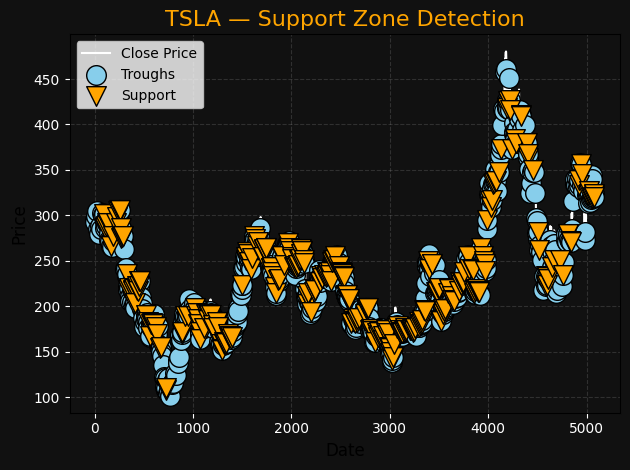

Resistance Range from Index 21: [310.48410369873045, 304.3359036254883]
Peak at index 10 in NOT within range.
Peak at index 14 in NOT within range.
Peak at index 18 in within range. Resistance Confirmed!
Resistance Range from Index 26: [310.2722280883789, 304.12822357177737]
Peak at index 10 in NOT within range.
Peak at index 14 in within range. Resistance Confirmed!
Peak at index 18 in within range. Resistance Confirmed!
Peak at index 21 in within range. Resistance Confirmed!
Resistance Range from Index 36: [304.93582305908205, 298.8974899291992]
Peak at index 18 in NOT within range.
Peak at index 21 in NOT within range.
Peak at index 26 in NOT within range.
Resistance Range from Index 49: [286.13301849365234, 280.4670181274414]
Peak at index 36 in NOT within range.
Resistance Range from Index 56: [297.2261584472656, 291.3404919433594]
Peak at index 36 in NOT within range.
Peak at index 49 in NOT within range.
Resistance Range from Index 73: [312.94779724121094, 306.75081115722656]
Pe

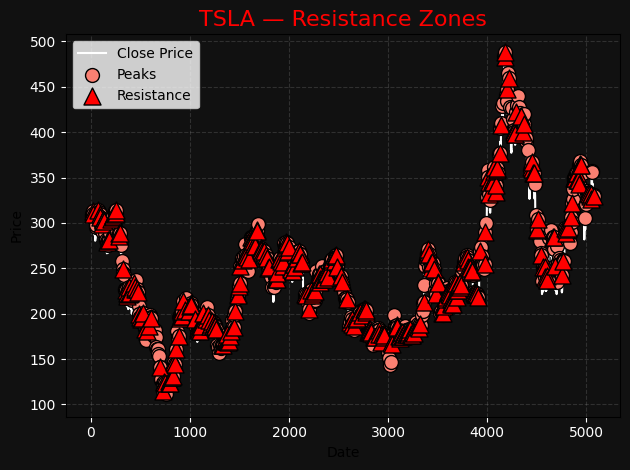

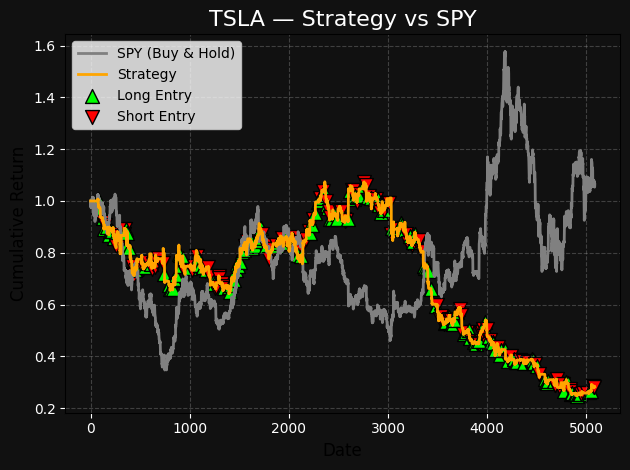

In [57]:
TICKER = 'TSLA'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RANGE = .02
WINDOW = 5
DURATION = 20
HOLDING_PERIOD = 5

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def indendify_lows(df, window=WINDOW):
    
    df = df.copy()
    df['Trough'] = 0

    rolling_min = df['Low'].rolling(window, center=True).min()
    df['Trough'] = np.where(df['Low'] == rolling_min, 1, 0)

    return df

def identify_highs(df, window=WINDOW):

    df = df.copy()
    df['Peak'] = 0

    rolling_max = df['High'].rolling(window, center=True).max()
    df['Peak'] = np.where(df['High'] == rolling_max, 1, 0)

    return df

def identify_support(df, ticker=TICKER, duration=DURATION, range=RANGE):
    df = df.copy()
    df = df.reset_index(drop=True)

    # initialize empty support column
    df['Support'] = 0

    # get rows of all instances with troughs
    indices = df.index[df['Trough'] == 1]
    for i in indices:

        # cycle through all rows after your study duration length
        if i >= duration:

            # subset of information relating to what happened {DURATION} periods before you encountered your trough
            info = df.iloc[i-duration:i]
            range_max = info['Close'].values[-1] + (info['Close'].values[-1] * (range/2))
            range_min = info['Close'].values[-1] - (info['Close'].values[-1] * (range/2))

            print(f'Support Range from Index {i}: [{range_max}, {range_min}]')

            other_instance = info.iloc[:-1][info.iloc[:-1]['Trough'] == 1]
            instance_in_range = False

            for idx, trough_row in other_instance.iterrows():
                close_price = trough_row['Close']
                if range_min <= close_price <= range_max:
                    instance_in_range = True
                    print(f'Trough at index {idx} in within range. Support Confirmed!')
                else:
                    print(f'Trough at index {idx} in NOT within range.')

            # say we found support if 2 troughs appear within the specified range in the specified time period
            if instance_in_range:
                df.loc[i, 'Support'] = 1

    plt.figure()

    # Plot the closing price
    plt.plot(df.index, df['Close'], label='Close Price', color='white', linewidth=1.5)

    # Plot lows (troughs) with blue circles
    troughs = df[df['Trough'] == 1]
    plt.scatter(troughs.index, troughs['Low'], color='skyblue', label='Troughs', s=200, marker='o', edgecolors='black', zorder=4)

    # Plot confirmed support levels with orange downward triangles
    support_points = df[df['Support'] == 1]
    plt.scatter(support_points.index, support_points['Low'], color='orange', label='Support', s=200, marker='v', edgecolors='black', zorder=5)

    # Styling
    plt.title(f"{ticker} — Support Zone Detection", fontsize=16, color='orange')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.gca().set_facecolor('#111')
    plt.gcf().patch.set_facecolor('#111')
    plt.tick_params(colors='white')

    plt.show()

    return df

def identify_resistance(df, ticker=TICKER, duration=DURATION, range=RANGE):
    df = df.copy()
    df = df.reset_index(drop=True)

    # initialize empty support column
    df['Resistance'] = 0

    # get rows of all instances with troughs
    indices = df.index[df['Peak'] == 1]
    for i in indices:

        # cycle through all rows after your study duration length
        if i >= duration:

            # subset of information relating to what happened {DURATION} periods before you encountered your trough
            info = df.iloc[i-duration:i]
            range_max = info['Close'].values[-1] + (info['Close'].values[-1] * (range/2))
            range_min = info['Close'].values[-1] - (info['Close'].values[-1] * (range/2))

            print(f'Resistance Range from Index {i}: [{range_max}, {range_min}]')

            other_instance = info.iloc[:-1][info.iloc[:-1]['Peak'] == 1]
            instance_in_range = False

            for idx, peak_row in other_instance.iterrows():
                close_price = peak_row['Close']
                if range_min <= close_price <= range_max:
                    instance_in_range = True
                    print(f'Peak at index {idx} in within range. Resistance Confirmed!')
                else:
                    print(f'Peak at index {idx} in NOT within range.')

            # say we found support if 2 troughs appear within the specified range in the specified time period
            if instance_in_range:
                df.loc[i, 'Resistance'] = 1

    plt.figure()

    plt.plot(df.index, df['Close'], label='Close Price', color='white', linewidth=1.5)

    # Peaks (salmon)
    peaks = df[df['Peak'] == 1]
    plt.scatter(peaks.index, peaks['High'], color='salmon', label='Peaks', s=100, marker='o', edgecolors='black', zorder=4)

    # Resistance (red)
    resistance_points = df[df['Resistance'] == 1]
    plt.scatter(resistance_points.index, resistance_points['High'], color='red', label='Resistance', s=150, marker='^', edgecolors='black', zorder=5)

    plt.title(f"{ticker} — Resistance Zones", fontsize=16, color='red')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.gca().set_facecolor('#111')
    plt.gcf().patch.set_facecolor('#111')
    plt.tick_params(colors='white')

    plt.show()

    return df

def strategy(df, holding_period=HOLDING_PERIOD):
    df = df.copy()
    df['Strategy'] = 0

    support = df['Support'].to_numpy()
    resistance = df['Resistance'].to_numpy()
    close = df['Close'].to_numpy()
    strategy = np.zeros(len(df))

    for i in range(len(df)):
        # Support breakout → go short
        if support[i] == 1:
            support_level = close[i]
            for j in range(i + 1, len(df)):
                if close[j] <= support_level and j + 1 < len(df):
                    strategy[j + 1 : j + 1 + holding_period] = -1
                    break

        # Resistance breakout → go long
        if resistance[i] == 1:
            resistance_level = close[i]
            for j in range(i + 1, len(df)):
                if close[j] >= resistance_level and j + 1 < len(df):
                    strategy[j + 1 : j + 1 + holding_period] = 1
                    break


    df['Strategy'] = strategy
    return df

def plot_strategy_comparison(df, ticker=TICKER):
    df = df.copy()

    # Calculate returns
    df['Return'] = df['Close'].pct_change().fillna(0)
    df['Strategy_Return'] = df['Return'] * df['Strategy']

    # Calculate cumulative returns
    df['Cumulative_SPY'] = (1 + df['Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()

    # Find entry points using NumPy logic
    strategy = df['Strategy'].to_numpy()
    entry_indices = np.where((strategy != 0) & (np.roll(strategy, 1) == 0))[0]

    # Plotting
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Cumulative_SPY'], label='SPY (Buy & Hold)', color='gray', linewidth=2)
    ax.plot(df.index, df['Cumulative_Strategy'], label='Strategy', color='orange', linewidth=2)

    # Entry markers
    for idx in entry_indices:
        entry_type = strategy[idx]
        if entry_type == 1:
            ax.scatter(df.index[idx], df['Cumulative_Strategy'].iloc[idx],
                       color='lime', edgecolor='black', marker='^', s=100, label='Long Entry')
        elif entry_type == -1:
            ax.scatter(df.index[idx], df['Cumulative_Strategy'].iloc[idx],
                       color='red', edgecolor='black', marker='v', s=100, label='Short Entry')

    # De-duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    deduped = []
    for h, l in zip(handles, labels):
        if l not in seen:
            deduped.append((h, l))
            seen.add(l)
    ax.legend(*zip(*deduped))

    ax.set_title(f"{ticker} — Strategy vs SPY", fontsize=16, color='white')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Cumulative Return", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_facecolor('#111')
    fig.patch.set_facecolor('#111')
    ax.tick_params(colors='white')
    plt.tight_layout()
    plt.show()

def main():
    df = get_data()
    df = indendify_lows(df)
    df = identify_highs(df)
    df = identify_support(df)
    df = identify_resistance(df)
    df = strategy(df)
    df = plot_strategy_comparison(df)
    return df

df = main()